In [9]:
using Revise
@time using CairoMakie      # For plotting (incluing tableau diagrams)
@time using Quantikz        # For drawing quantum circuits
@time using QuantumClifford # For quantum Clifford circuits
@time using QuantumClifford.ECC: parity_checks, Steane7, Shor9, naive_syndrome_circuit
include("util/CSS_builder.jl")
using Main.CSS_Builder
@show Threads.nthreads();
using LinearAlgebra
using Combinatorics: combinations

  0.000991 seconds (456 allocations: 30.539 KiB)
  0.000991 seconds (456 allocations: 30.539 KiB)
  0.001327 seconds (456 allocations: 30.539 KiB)
  0.001918 seconds (456 allocations: 30.539 KiB)
Threads.nthreads() = 1


In [2]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 12 × AMD Ryzen 5 5600X 6-Core Processor             
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver3)
  Threads: 1 on 12 virtual cores
Environment:
  JULIA_NUM_THREADS = 


In [3]:
"""A helper function used later on to plot the performance of a code."""
function plot_code_performance(error_rates, post_ec_error_rates; title="")
    f = Figure(resolution=(500,300))
    ax = f[1,1] = Axis(f, xlabel="single (qu)bit error rate",title=title)
    ax.aspect = DataAspect()
    lim = max(error_rates[end],post_ec_error_rates[end])
    lines!([0,lim], [0,lim], label="single bit", color=:black)
    plot!(error_rates, post_ec_error_rates, label="after decoding", color=:black)
    xlims!(0,lim)
    ylims!(0,lim)
    f[1,2] = Legend(f, ax, "Error Rates")
    f
end;

In [4]:
make_noisy(gate,noise) = gate
make_noisy(gate::sCNOT,noise) = NoisyGate(gate,noise)
make_noisy(gates::Vector,noise) = make_noisy.(gates,(noise,)); # TODO move to quantum clifford

# A Brief Error Correction Tutorial with `QuantumClifford.jl`

Typical "error correction" is based on using many (qu)bits with (linear) redundancies between them to encode fewer more error-resilient (qu)bits. We will go through a few examples in the classical and quantum case.

We will estimate the logical error rate of various codes (the error rates after attempts at correction) for a given physical error rate (the error rate of the underlying physical (qu)bits).

## Classical Linear Codes

### Example with a simple repetition code on three bits

Consider the repetion code on three bits:

In [5]:
# Parity check matrix
Hᵣₑₚ₃ = [1 1 0;
         0 1 1]

# A code word
code_word = [1
             1
             1];

It fulfills the parity constraints $H\cdot \vec{c} = 0$

In [6]:
 (Hᵣₑₚ₃ * code_word) .% 2

2-element Vector{Int64}:
 0
 0

Consider an error:

In [7]:
error = [1
         0
         0];

The parity constraint is broken if we apply the error

In [8]:
(Hᵣₑₚ₃ * (error .⊻ code_word)) .% 2

2-element Vector{Int64}:
 1
 0

### Notice the pattern of failed constraints (the syndrome) does not depend on the code word

### $H\cdot\left(\vec{e} + \vec{c}\right)$

### $H\cdot\left(\vec{e} + \vec{c}\right) = H\cdot\vec{e} + H\cdot\vec{c}$

### $H\cdot\left(\vec{e} + \vec{c}\right) = H\cdot\vec{e} + H\cdot\vec{c} = H\cdot\vec{e}$

### $H\cdot\left(\vec{e} + \vec{c}\right) = H\cdot\vec{e} + H\cdot\vec{c} = H\cdot\vec{e} = \vec{s}$

### Error correction = Syndrome decoding

#### Mapping $\vec{s} \rightarrow \vec{e}$

Performing the decoding efficiently is a difficult task, target of many research efforts. Evaluating the usefulness of a code frequently involves not only studying the abstract properties of the code, but also the tradeoffs between different available decoders. For the purpose of this tutorial, we will create trivial "look-up table" decoders, which become incredibly inefficient as the size of the code grows. To evaluate another decoder, simply plug it in instead of the lookup table.

In [9]:
"""Generate a lookup table for decoding single bit errors. Maps s⃗ → e⃗."""
function create_lookup_table(H)
    lookup_table = Dict()
    constraints, bits = size(H)
    # In the case of no errors
    lookup_table[ zeros(Int, constraints) ] = zeros(Int, bits)
    # In the case of single bit errors
    for bit_to_be_flipped in 1:bits
        # Generate e⃗
        error = zeros(Int, bits)
        error[bit_to_be_flipped] = 1
        # Calculate s⃗
        syndrome = (H*error) .% 2
        # Store s⃗ → e⃗
        lookup_table[syndrome] = error
    end
    lookup_table
end;

In [10]:
rep3_lookup_table = create_lookup_table(Hᵣₑₚ₃)

Dict{Any, Any} with 4 entries:
  [0, 0] => [0, 0, 0]
  [1, 1] => [0, 1, 0]
  [1, 0] => [1, 0, 0]
  [0, 1] => [0, 0, 1]

### Monte Carlo evaluation of the code **and** decoder

We will repeatedly generate random errors and see what fraction of them we successfully correct.

In [11]:
"""For a given physical bit-flip error rate, parity check matrix, and a lookup table,
estimate logical error rate"""
function evaluate_code_decoder(H,lookup_table,p; samples=10_000)
    constraints, bits = size(H)
    decoded = 0 # Counts correct decodings
    for sample in 1:samples
        error = rand(bits) .< p                    # Generate random error
        syndrome = (H*error) .% 2                  # Apply that error to your physical system and get syndrome
        guess = get(lookup_table,syndrome,nothing) # Decode the syndrome
        if guess==error                            # Check if you were right
            decoded += 1
        end
    end
    1 - decoded / samples
end;

In [12]:
error_rates = 0.01:0.05:0.5
@time post_ec_error_rates = [evaluate_code_decoder(Hᵣₑₚ₃,rep3_lookup_table,p) for p in error_rates];

  1.632417 seconds (1.08 M allocations: 70.351 MiB, 1.17% gc time, 85.35% compilation time)


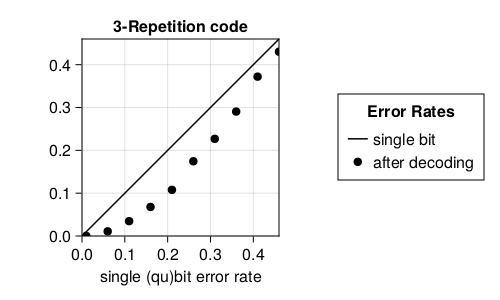

In [13]:
plot_code_performance(error_rates, post_ec_error_rates, title="3-Repetition code")

## Quantum Error Correction

### Steane's 7-qubit code

We will pick the Steane code as the first quantum code for which to perform the same estimates. In the case of a quantum code, the binary parity check matrix becomes the stabilizer tableau (a matrix where each element corresponds to a Pauli operator). The parity being checked now, is the parity corresponding to a multi-qubit measurement in the given Pauli basis.

In [14]:
codeˢᵗᵉᵃⁿᵉ = parity_checks(Steane7())

+ ___XXXX
+ _XX__XX
+ X_X_X_X
+ ___ZZZZ
+ _ZZ__ZZ
+ Z_Z_Z_Z

### Single-Shot Error Correction Estimates against Pauli noise on non-degenerate codes

We will consider only Pauli noise for the moment. And we will consider only situations in which the syndrome is measured and decoded once.

We will assume that all encoding/decoding quantum operations are perfect here. I.e. we are estimating error correction performance of a quantum memory/channel with perfect circuitry but noisy storage/transmission, not the fault tollerance performance of a noisy quantum computer.

Our first setup would be capable of evaluating only non-degenerate codes.

In [15]:
"""Generate a lookup table for decoding single qubit errors. Maps s⃗ → e⃗."""
function create_lookup_table(code::Stabilizer)
    lookup_table = Dict()
    constraints, qubits = size(code)
    # In the case of no errors
    lookup_table[ zeros(UInt8, constraints) ] = zero(PauliOperator, qubits)
    # In the case of single bit errors
    for bit_to_be_flipped in 1:qubits
        for error_type in [single_x, single_y, single_z]
            # Generate e⃗
            error = error_type(qubits, bit_to_be_flipped)
            # Calculate s⃗
            # (check which stabilizer rows do not commute with the Pauli error)
            syndrome = comm(error, code)
            # Store s⃗ → e⃗
            lookup_table[syndrome] = error
        end
    end
    lookup_table
end;

The lookup table for the Steane code contains an entry for all $3\times 7=21$ single-qubit errors and an extra entry for no errors.

In [16]:
steane_table = create_lookup_table(codeˢᵗᵉᵃⁿᵉ)

Dict{Any, Any} with 22 entries:
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x01] => + __X____
  UInt8[0x01, 0x01, 0x00, 0x00, 0x00, 0x00] => + _____Z_
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x00] => + _X_____
  UInt8[0x01, 0x00, 0x01, 0x01, 0x00, 0x01] => + ____Y__
  UInt8[0x00, 0x01, 0x01, 0x00, 0x00, 0x00] => + __Z____
  UInt8[0x01, 0x00, 0x00, 0x01, 0x00, 0x00] => + ___Y___
  UInt8[0x00, 0x01, 0x01, 0x00, 0x01, 0x01] => + __Y____
  UInt8[0x01, 0x00, 0x01, 0x00, 0x00, 0x00] => + ____Z__
  UInt8[0x00, 0x01, 0x00, 0x00, 0x00, 0x00] => + _Z_____
  UInt8[0x00, 0x01, 0x00, 0x00, 0x01, 0x00] => + _Y_____
  UInt8[0x01, 0x00, 0x00, 0x00, 0x00, 0x00] => + ___Z___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x01] => + ____X__
  UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01] => + ______Y
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x00] => + ___X___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x01, 0x01] => + ______X
  UInt8[0x00, 0x00, 0x01, 0x00, 0x00, 0x01] => + Y______
  UInt8[0x00, 0x00, 0x00, 0x01, 0x01, 0x00] => + _____X_

In [17]:
bicycle_code = S
"XXIXIIIXIIIXIX
IXXIXIIXXIIIXI
IIXXIXIIXXIIIX
IIIXXIXXIXXIII
XIIIXXIIXIXXII
IXIIIXXIIXIXXI
XIXIIIXIIIXIXX
ZZIZIIIZIIIZIZ
IZZIZIIZZIIIZI
IIZZIZIIZZIIIZ
IIIZZIZZIZZIII
ZIIIZZIIZIZZII
IZIIIZZIIZIZZI
ZIZIIIZIIIZIZZ
"

+ XX_X___X___X_X
+ _XX_X__XX___X_
+ __XX_X__XX___X
+ ___XX_XX_XX___
+ X___XX__X_XX__
+ _X___XX__X_XX_
+ X_X___X___X_XX
+ ZZ_Z___Z___Z_Z
+ _ZZ_Z__ZZ___Z_
+ __ZZ_Z__ZZ___Z
+ ___ZZ_ZZ_ZZ___
+ Z___ZZ__Z_ZZ__
+ _Z___ZZ__Z_ZZ_
+ Z_Z___Z___Z_ZZ

In [10]:
bn = 1000;
dn = 25;
b7 = AssembleCSS(Circ2BicycleH(BicycleSetGen(bn), bn));
# b7 = AssembleCSS(b7h, b7h);
phase_arr = fill(0x0, 2*bn);
sb1000 = Stabilizer(phase_arr, GetXTableau(b7), GetZTableau(b7))

+ XX_X___X____X_______X_________X_____⋯_______X_________X_______X____X___X_X
+ _XX_X___X____X_______X_________X____⋯________X_________X_______X____X___X_
+ __XX_X___X____X_______X_________X___⋯_________X_________X_______X____X___X
+ ___XX_X___X____X_______X_________X__⋯__________X_________X_______X____X___
+ ____XX_X___X____X_______X_________X_⋯___________X_________X_______X____X__
+ _____XX_X___X____X_______X_________X⋯____________X_________X_______X____X_
+ ______XX_X___X____X_______X_________⋯_____________X_________X_______X____X
+ _______XX_X___X____X_______X________⋯X_____________X_________X_______X____
+ ________XX_X___X____X_______X_______⋯_X_____________X_________X_______X___
 ⋮
+ ____Z_______Z_________Z_____________⋯_________Z_______Z____Z___Z_ZZ_______
+ Z____Z_______Z_________Z____________⋯Z_________Z_______Z____Z___Z_ZZ______
+ _Z____Z_______Z_________Z___________⋯_Z_________Z_______Z____Z___Z_ZZ_____
+ __Z____Z_______Z_________Z__________⋯__Z_________Z_______Z____Z___Z_ZZ_

In [11]:
function isdegenerate(H::Stabilizer, errors) # Described in https://quantumcomputing.stackexchange.com/questions/27279
    syndromes = comm.((H,), errors) # TODO This can be optimized by having something that always returns bitvectors
    return length(Set(syndromes)) != length(errors)
end

function isdegenerate(H::Stabilizer, d::Int=1)
    n = nqubits(H)
    errors = [begin p=zero(PauliOperator,n); for i in bits; p[i]=op; end; p end for bits in combinations(1:n, d) for op in ((true,false), (false,true))]
    return isdegenerate(H, errors)
end

isdegenerate (generic function with 2 methods)

In [12]:
print(isdegenerate(sb1000))

MethodError: MethodError: no method matching isdegenerate(::Stabilizer{QuantumClifford.Tableau{Vector{UInt8}, Matrix{UInt64}}}, ::Vector{PauliOperator{Array{UInt8, 0}, Vector{UInt64}}})

Closest candidates are:
  isdegenerate(::Stabilizer)
   @ Main c:\Users\benku\Desktop\College documents\Krastanov Independent Study\Error_Correction_Tutorial.ipynb:1
  isdegenerate(::Stabilizer, !Matched::Int64)
   @ Main c:\Users\benku\Desktop\College documents\Krastanov Independent Study\Error_Correction_Tutorial.ipynb:1


In [38]:
unicycle_code = S"XXIIXIXIIIIIIX
IXXIIXIXIIIIIX
IIXXIIXIXIIIIX
IIIXXIIXIXIIIX
IIIIXXIIXIXIIX
IIIIIXXIIXIXIX
IIIIIIXXIIXIXX
XIIIIIIXXIIXIX
IXIIIIIIXXIIXX
XIXIIIIIIXXIIX
IXIXIIIIIIXXIX
IIXIXIIIIIIXXX
XIIXIXIIIIIIXX
ZZIIZIZIIIIIIZ
IZZIIZIZIIIIIZ
IIZZIIZIZIIIIZ
IIIZZIIZIZIIIZ
IIIIZZIIZIZIIZ
IIIIIZZIIZIZIZ
IIIIIIZZIIZIZZ
ZIIIIIIZZIIZIZ
IZIIIIIIZZIIZZ
ZIZIIIIIIZZIIZ
IZIZIIIIIIZZIZ
IIZIZIIIIIIZZZ
ZIIZIZIIIIIIZZ"

+ XX__X_X______X
+ _XX__X_X_____X
+ __XX__X_X____X
+ ___XX__X_X___X
+ ____XX__X_X__X
+ _____XX__X_X_X
+ ______XX__X_XX
+ X______XX__X_X
+ _X______XX__XX
 ⋮
+ _____ZZ__Z_Z_Z
+ ______ZZ__Z_ZZ
+ Z______ZZ__Z_Z
+ _Z______ZZ__ZZ
+ Z_Z______ZZ__Z
+ _Z_Z______ZZ_Z
+ __Z_Z______ZZZ
+ Z__Z_Z______ZZ

In [18]:
bicycle_table = create_lookup_table(bicycle_code) # 14*3 + 1 entries

Dict{Any, Any} with 43 entries:
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯__X___
  UInt8[0x00, 0x01, 0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00,… => + __Z__⋯______
  UInt8[0x01, 0x00, 0x00, 0x00, 0x01, 0x01, 0x00, 0x00, 0x00,… => + _____⋯___Z__
  UInt8[0x00, 0x01, 0x01, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01,… => + __Y__⋯______
  UInt8[0x01, 0x00, 0x00, 0x00, 0x01, 0x01, 0x00, 0x01, 0x00,… => + _____⋯___Y__
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01,… => + _____⋯X_____
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00,… => + X____⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x01,… => + _X___⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01,… => + __X__⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00,… => + _____⋯___

In [39]:
unicycle_table = create_lookup_table(unicycle_code)

Dict{Any, Any} with 43 entries:
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + ____X⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯X_____
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x00, 0x01,… => + _____⋯_Z____
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯____X_
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯______
  UInt8[0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00,… => + Z____⋯______
  UInt8[0x00, 0x00, 0x01, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00,… => + ___Z_⋯______
  UInt8[0x01, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01,… => + _Z___⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + __X__⋯______
  UInt8[0x00, 0x01, 0x00, 0x00, 0x01, 0x01, 0x00, 0x00, 0x00,… => + _____⋯______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,… => + _____⋯______
  UInt8[0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x00, 0x01, 0x01,… => + _____⋯Z__

In [19]:
"""For a given physical bit-flip error rate, parity check matrix, and a lookup table,
estimate logical error rate, assuming non-degenerate code."""
function evaluate_code_decoder(code::Stabilizer,lookup_table,p; samples=10_000)
    constraints, qubits = size(code)
    decoded = 0 # Counts correct decodings
    for sample in 1:samples
        # Generate random error
        error = random_pauli(qubits,p/3,nophase=true)
        # Apply that error to your physical system
        # and get syndrome
        syndrome = comm(error, code)
        # Decode the syndrome
        guess = get(lookup_table,syndrome,nothing)
        # check if you were right
        if guess==error
            decoded += 1
        end
    end
    1 - decoded / samples
    end;

  0.492159 seconds (5.89 M allocations: 199.859 MiB, 13.83% gc time, 26.42% compilation time)


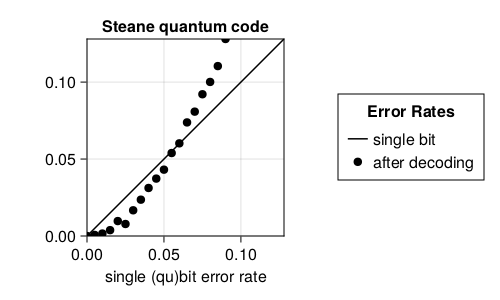

In [20]:
error_rates = 0.000:0.005:0.09
@time post_ec_error_rates = [evaluate_code_decoder(codeˢᵗᵉᵃⁿᵉ, steane_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

  0.728636 seconds (11.13 M allocations: 368.816 MiB, 12.45% gc time, 3.51% compilation time)


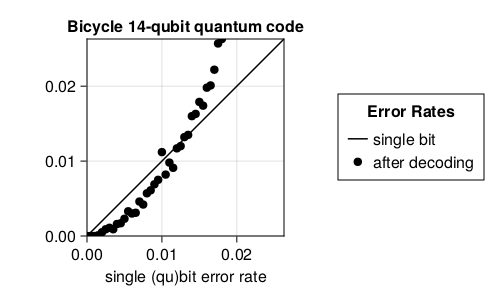

In [60]:
error_rates = 0.000:0.0005:0.018
@time post_ec_error_rates = [evaluate_code_decoder(bicycle_code, bicycle_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Bicycle 14-qubit quantum code")

  0.746176 seconds (11.13 M allocations: 374.432 MiB, 12.88% gc time, 2.68% compilation time)


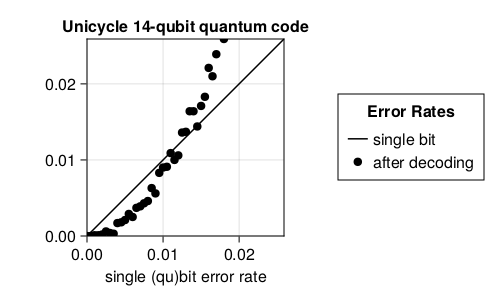

In [61]:
error_rates = 0.000:0.0005:0.018
@time post_ec_error_rates = [evaluate_code_decoder(unicycle_code, unicycle_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Unicycle 14-qubit quantum code")

### Shor's 9-qubit code

Shor's code is degenerate (a property to be explained shortly), which requires a slight modification to our approach.

In [25]:
codeˢʰᵒʳ = parity_checks(Shor9())

+ ZZ_______
+ _ZZ______
+ ___ZZ____
+ ____ZZ___
+ ______ZZ_
+ _______ZZ
+ XXXXXX___
+ ___XXXXXX

We will attempt the same form of performance evaluation as above for the Shor code.

  0.376003 seconds (5.73 M allocations: 190.257 MiB, 14.48% gc time, 5.74% compilation time)


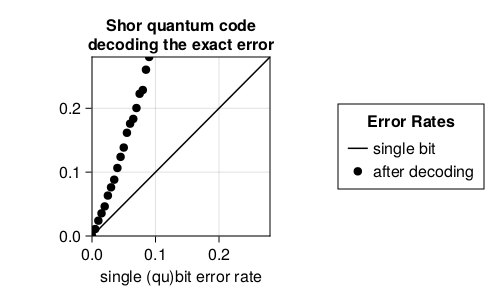

In [26]:
shor_table = create_lookup_table(codeˢʰᵒʳ)
error_rates = 0.000:0.005:0.09
@time post_ec_error_rates = [evaluate_code_decoder(codeˢʰᵒʳ, shor_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Shor quantum code\ndecoding the exact error")

It looks like the performance is much worse than no code at all. Looking at the lookup table, we see it has fewer than the expected $3\times 9+1=28$ entries (for each of the possible single qubit errors and one for no errors).

In [27]:
shor_table

Dict{Any, Any} with 22 entries:
  UInt8[0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00] => + __Y______
  UInt8[0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00] => + X________
  UInt8[0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00] => + Y________
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00] => + _____X___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x01, 0x01] => + _____Y___
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x01, 0x00, 0x01] => + _______Y_
  UInt8[0x01, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00] => + _X_______
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x01, 0x00, 0x00] => + _______X_
  UInt8[0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00] => + ___X_____
  UInt8[0x01, 0x01, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00] => + _Y_______
  UInt8[0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x01, 0x01] => + ___Y_____
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01] => + ________Y
  UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00] => + ________X
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0

This is due to the degeneracy of Shor's code: different errors could (1) correspond to the same syndrome and (2) lead to the same logical flips:

In [28]:
comm(P"Z________", codeˢʰᵒʳ) 

8-element Vector{UInt8}:
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x01
 0x00

In [29]:
comm(P"_Z_______", codeˢʰᵒʳ)

8-element Vector{UInt8}:
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x01
 0x00

This is not necessary a problem as long as the correction operation for the first error is also a correction operation for the second error:

In [30]:
comm(P"_Z_______" * P"Z________", codeˢʰᵒʳ)

8-element Vector{UInt8}:
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00
 0x00

In [31]:
full_tableau = MixedDestabilizer(codeˢʰᵒʳ)
print(full_tableau)
logicals = vcat(logicalxview(full_tableau),logicalzview(full_tableau))
logicals # the logical observables

𝒟ℯ𝓈𝓉𝒶𝒷━━━━━
+ Z________
+ ___Z_____
+ _X_______
+ __X______
+ ____X____
+ _____X___
+ ______X__
+ _______X_
𝒳ₗ━━━━━━━━━
+ ______XXX
𝒮𝓉𝒶𝒷━━━━━━━
+ XXX___XXX
+ ___XXXXXX
+ ZZ_______
+ Z_Z______
+ ___ZZ____
+ ___Z_Z___
+ ______Z_Z
+ _______ZZ
𝒵ₗ━━━━━━━━━0
+ Z__Z____Z

+ ______XXX
+ Z__Z____Z

In [32]:
comm(P"_Z_______" * P"Z________", logicals)

2-element Vector{UInt8}:
 0x00
 0x00

Which leads to a small modification in our Monte Carlo evaluation code.

In [33]:
"""For a given physical bit-flip error rate, parity check matrix, and a lookup table,
estimate logical error rate, taking into account the code might be degenerate."""
function evaluate_degen_code_decoder(code::Stabilizer,lookup_table,p; samples=10_000)
    constraints, qubits = size(code)
    full_tableau = MixedDestabilizer(code)
    logicals = vcat(logicalxview(full_tableau),logicalzview(full_tableau))
    decoded = 0 # Counts correct decodings
    for sample in 1:samples
        # Generate random error
        error = random_pauli(qubits,p/3,nophase=true)
        # Apply that error to your physical system
        # and get syndrome
        syndrome = comm(error, code)
        # Decode the syndrome
        guess = get(lookup_table,syndrome,nothing)
        # Check if the suggested error correction
        # corrects the error or if it is equivalent
        # to a logical operation
        if !isnothing(guess) && all(==(0x0), comm(guess*error, code)) && all(==(0x0), comm(guess*error, logicals))
            decoded += 1
        end
    end
    1 - decoded / samples
end;

With the degeneracy taken into account, the Shor code works fine

  0.863832 seconds (8.87 M allocations: 368.457 MiB, 12.37% gc time, 52.05% compilation time)


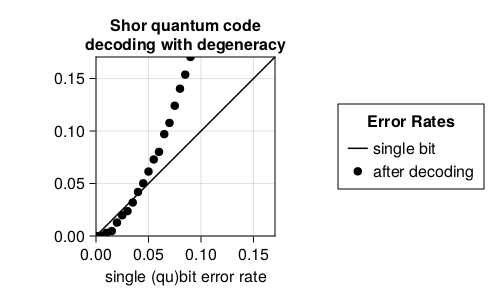

In [34]:
@time post_ec_error_rates = [evaluate_degen_code_decoder(codeˢʰᵒʳ, shor_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Shor quantum code\ndecoding with degeneracy")

  0.893070 seconds (14.88 M allocations: 563.209 MiB, 14.93% gc time, 2.38% compilation time)


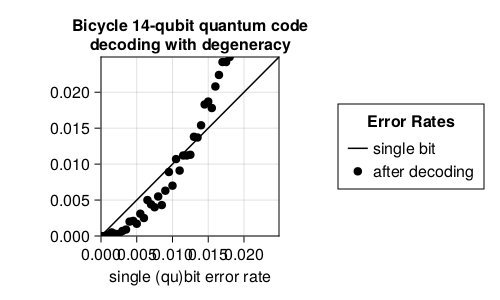

In [63]:
error_rates = 0.000:0.0005:0.018
@time post_ec_error_rates = [evaluate_degen_code_decoder(bicycle_code, bicycle_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Bicycle 14-qubit quantum code\ndecoding with degeneracy")

  0.956673 seconds (14.92 M allocations: 576.150 MiB, 15.01% gc time, 2.18% compilation time)


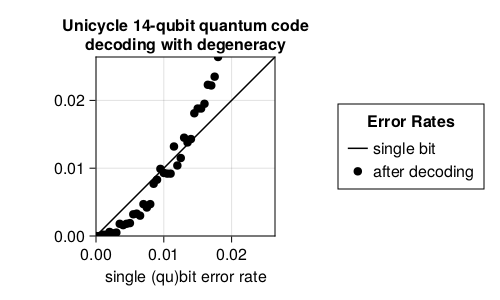

In [62]:
error_rates = 0.000:0.0005:0.018
@time post_ec_error_rates = [evaluate_degen_code_decoder(unicycle_code, unicycle_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Unicycle 14-qubit quantum code\ndecoding with degeneracy")

# Not covered

- The stabilizer formalism: interpreting a code tableau as a state
- Families of codes: pseudothreshold vs threshold
- Non-Pauli errors and Coherent errors
- Good codes: Low Density Parity Checks and Expander Graphs
- Good decoders: belief propagation and iterative decoders
- Faster simulations: Pauli frames and fault matrices
- Error Correction vs Fault Tolerance

# What follows are unpolished lecture materials

## An asside: The Code Tableau can be Interpreted as a State Tableau

In [42]:
S"XX"

+ XX

## Complexity

For a code on $n$ qubits with $m$ constraints it takes $\mathcal{O}(nm)$ steps to calculate a syndrome given an error. It takes the same amount of time to check whether a given correction procedure fixes a given error. Notice we need to track the evolution of a single Pauli string of size $\mathcal{O}(n)$, instead of tracking a whole stabilizer (which would have taken $\mathcal{O}(n^2m)$). However, the naive way we are doing it makes it viable only for the simulation of perfect circuits. We need a more sophisticated "Pauli Frame" simulation to retain this high performance for noisy circuits and fault tolerance simulations.

But even the naive approach is only quadratically slow, not exponentially slow like if we had used kets or density matrices.

## Error Correction vs Fault Tolerance

What if we had not only memory/transmission noise, but also operational noise? I.e., each of the gates in the syndrome measurement circuit is itself noisy and might itself cause errors. We will explore this, and we will run through an example with the Steane's 7 qubit code.

### Syndrome Measurement Circuit

Up until now we just used the `comm` function to check whether certain operators commute. This is a good way to represent a perfect measurement, but now we want to simulate the actual circuit that would be performing the measurement. Here is one way to do it:

In [43]:
codeˢᵗᵉᵃⁿᵉ = parity_checks(Steane7())
print(codeˢᵗᵉᵃⁿᵉ)

@show s, n = size(codeˢᵗᵉᵃⁿᵉ)
@show k = n-s                 # logical qubits
@show anc = n+s;              # physical qubits + ancillary qubits

+ ___XXXX
+ _XX__XX
+ X_X_X_X
+ ___ZZZZ
+ _ZZ__ZZ
+ Z_Z_Z_Z(s, n) = size(codeˢᵗᵉᵃⁿᵉ) = (6, 7)
k = n - s = 1
anc = n + s = 13


In [44]:
codeˢᵗᵉᵃⁿᵉ[1] |> println

+ ___XXXX


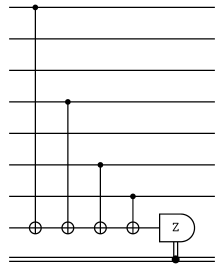

In [45]:
anc = n+1
[sCNOT(1,anc),sCNOT(4,anc),sCNOT(6,anc),sCNOT(7,anc),sMZ(anc,1)]

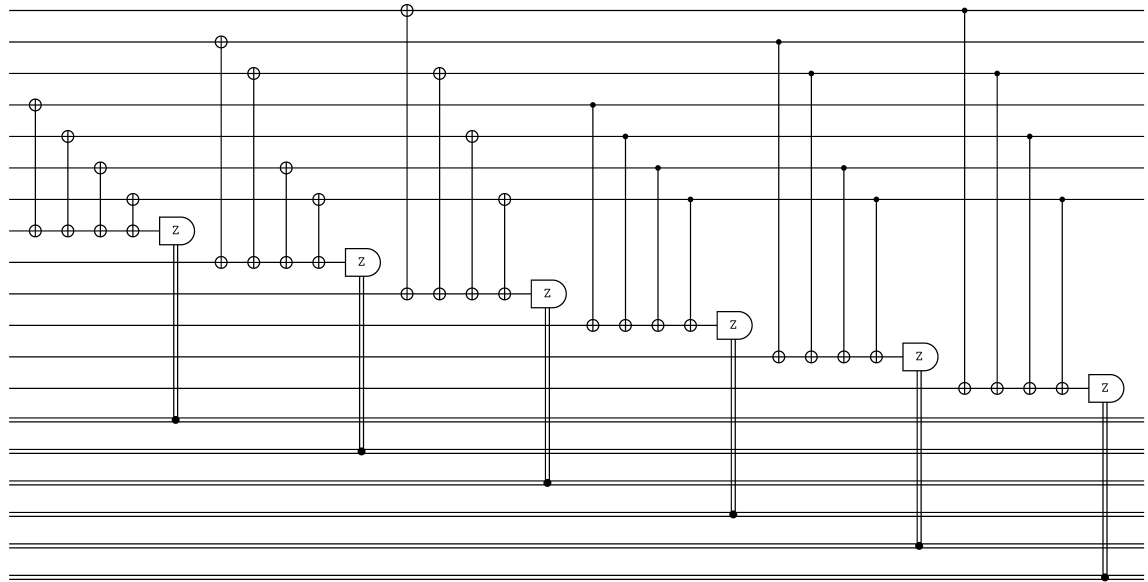

In [54]:
full_circuit = naive_syndrome_circuit(codeˢᵗᵉᵃⁿᵉ)

In [54]:
"""For a given physical bit-flip error rate, parity check matrix, and a lookup table,
estimate logical error rate, taking into account noisy circuits."""
function evaluate_code_decoder_noisy_circuit(code::Stabilizer,lookup_table,p,q; samples=10_000)
    constraints, qubits = size(code)
    initial_state = state = Register(MixedDestabilizer(code ⊗ one(Stabilizer, s)),zeros(Bool,6))
    initial_state.stab.rank = qubits+constraints # TODO hackish and ugly, needs fixing
    no_error_state = canonicalize!(stabilizerview(traceout!(copy(initial_state),n+1:n+constraints))) # TODO rather ugly
    # prepare measurement circuit
    syndrome_circuit = naive_syndrome_circuit(code)
    noisy_circuit = make_noisy(syndrome_circuit, UnbiasedUncorrelatedNoise(q/3))
    mem_noise_op = NoiseOp(UnbiasedUncorrelatedNoise(p/3), 1:qubits)
    pad_ancilla_qubits = zero(PauliOperator, constraints) # TODO rather ugly
    decoded = 0 # Counts correct decodings
    for sample in 1:samples
        state = copy(initial_state)
        # Apply the initial memory error to your physical system
        apply!(state, mem_noise_op)
        # Run the syndrome measurement circuit
        mctrajectory!(state, noisy_circuit)
        syndrome = UInt8.(bitview(state))
        # Decode the syndrome
        guess = get(lookup_table,syndrome,nothing)
        if isnothing(guess)
            continue
        end
        # Apply the suggested correction
        apply!(state, guess ⊗ pad_ancilla_qubits)
        # Check for errors
        if no_error_state == canonicalize!(stabilizerview(traceout!(state,n+1:n+constraints))) # TODO rather ugly
            decoded += 1
        end
    end
    1 - decoded / samples
    end;

  0.309872 seconds (2.80 M allocations: 96.426 MiB, 18.62% gc time, 33.16% compilation time)


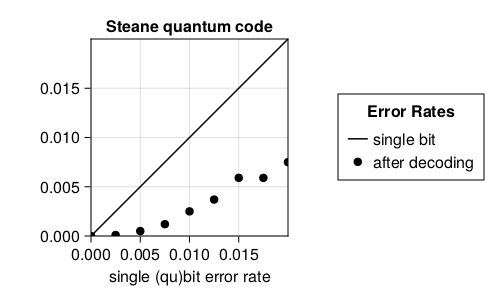

In [55]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder(codeˢᵗᵉᵃⁿᵉ, steane_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

  0.204337 seconds (2.73 M allocations: 91.075 MiB, 16.57% gc time, 9.86% compilation time)


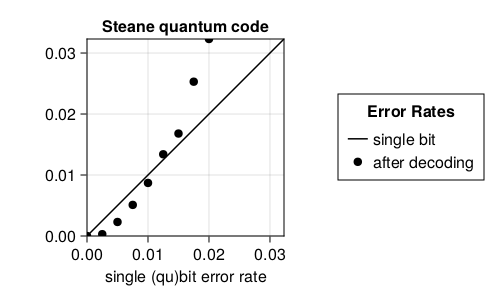

In [56]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder(bicycle_code, bicycle_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

  0.207885 seconds (2.73 M allocations: 92.463 MiB, 16.57% gc time, 9.39% compilation time)


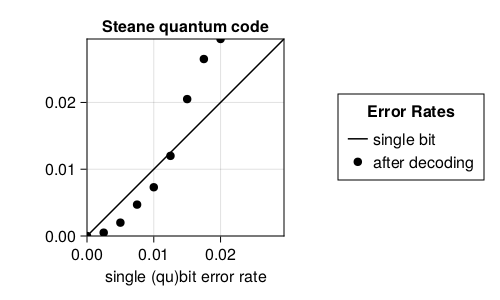

In [57]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder(unicycle_code, unicycle_table, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

  2.209371 seconds (34.83 M allocations: 1.176 GiB, 10.30% gc time, 12.60% compilation time)


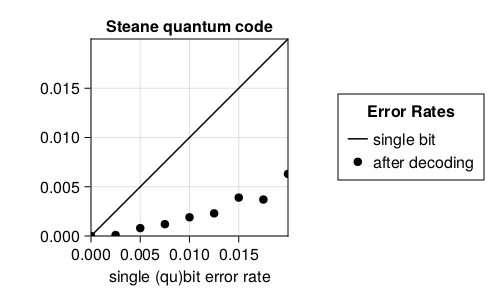

In [58]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder_noisy_circuit(codeˢᵗᵉᵃⁿᵉ, steane_table, p, 0.0) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

In [59]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder_noisy_circuit(bicycle_code, bicycle_table, p, 0.0) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

BoundsError: BoundsError: attempt to access 40-element Vector{UInt8} at index [21:48]

  1.952787 seconds (33.76 M allocations: 1.114 GiB, 10.14% gc time, 1.05% compilation time)


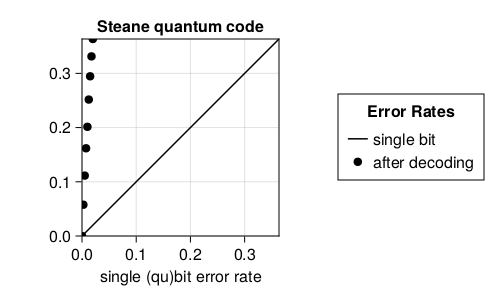

In [49]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder_noisy_circuit(codeˢᵗᵉᵃⁿᵉ, steane_table, p, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")

  1.905764 seconds (33.79 M allocations: 1.115 GiB, 10.24% gc time, 1.01% compilation time)


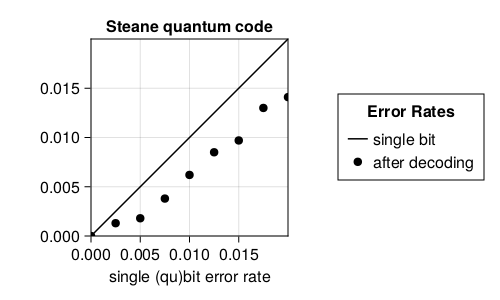

In [50]:
error_rates = 0.000:0.0025:0.02
@time post_ec_error_rates = [evaluate_code_decoder_noisy_circuit(codeˢᵗᵉᵃⁿᵉ, steane_table, p, p/50) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates, title="Steane quantum code")